In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings  # To suppress noisy warnings while keeping the code beginner-friendly
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Nice statistical plots

from sklearn.model_selection import StratifiedKFold  # Robust CV on imbalanced/shifted targets
from sklearn.metrics import roc_auc_score, log_loss  # Key metrics for probabilistic classifiers
from sklearn.preprocessing import StandardScaler  # Scaling numeric features
from sklearn.impute import SimpleImputer  # Safe imputation for missing values
from sklearn.compose import ColumnTransformer  # Apply different preprocessing to num/cat
from sklearn.pipeline import Pipeline  # Chain preprocessing + model safely
from sklearn.calibration import CalibratedClassifierCV  # Probability calibration for better log-loss
from sklearn.metrics import RocCurveDisplay  # Simple ROC plot helper

# We’ll use LightGBM for strong tabular performance and robustness.
# If not installed: pip install lightgbm
from lightgbm import LGBMClassifier 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv


# Load the data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')

In [3]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [4]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (700000, 25)
Test shape: (300000, 24)


In [5]:
train.head()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 25 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 700000 non-null  int64  
 1   alcohol_consumption_per_week        700000 non-null  int64  
 2   physical_activity_minutes_per_week  700000 non-null  int64  
 3   diet_score                          700000 non-null  float64
 4   sleep_hours_per_day                 700000 non-null  float64
 5   screen_time_hours_per_day           700000 non-null  float64
 6   bmi                                 700000 non-null  float64
 7   waist_to_hip_ratio                  700000 non-null  float64
 8   systolic_bp                         700000 non-null  int64  
 9   diastolic_bp                        700000 non-null  int64  
 10  heart_rate                          700000 non-null  int64  
 11  cholesterol_total         

In [7]:
target = 'diagnosed_diabetes'
cat_cols = test.select_dtypes(exclude='number').columns.to_list()
base = [col for col in train.columns if col not in [target]]
num_cols = [col for col in base if col not in cat_cols]

# EDA for Modeling

## Check for unique values and missing data

In [8]:
print('Null values for numerical data:', train[num_cols].isnull().sum().sum(), '\n')
print(train[num_cols].nunique(), '\n')
train[num_cols].head(4)

Null values for numerical data: 0 

age                                    71
alcohol_consumption_per_week            9
physical_activity_minutes_per_week    565
diet_score                             99
sleep_hours_per_day                    69
screen_time_hours_per_day             151
bmi                                   231
waist_to_hip_ratio                     36
systolic_bp                            71
diastolic_bp                           54
heart_rate                             60
cholesterol_total                     154
hdl_cholesterol                        69
ldl_cholesterol                       151
triglycerides                         228
family_history_diabetes                 2
hypertension_history                    2
cardiovascular_history                  2
dtype: int64 



,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,0,0,0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,0,0,0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,0,0,0
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,0,1,0


In [9]:
print('Null values for categorical data:', train[cat_cols].isnull().sum().sum(), '\n')
print(train[cat_cols].nunique(), '\n')
train[cat_cols].head(4)

Null values for categorical data: 0 

gender               3
ethnicity            5
education_level      4
income_level         5
smoking_status       3
employment_status    4
dtype: int64 



,gender,ethnicity,education_level,income_level,smoking_status,employment_status
0,Female,Hispanic,Highschool,Lower-Middle,Current,Employed
1,Female,White,Highschool,Upper-Middle,Never,Employed
2,Male,Hispanic,Highschool,Lower-Middle,Never,Retired
3,Female,White,Highschool,Lower-Middle,Current,Employed


### Observation

* No missing values: The dataset is clean and there is no missing values.
* Low cardinality: Even the numerical features exhibit low cardinality/ low unique value counts considering the data size of 700,000 rows. The possible reason for low cardinality could be signals were intentionally compressed by Kaggle
* Possible strategy: Since both numerical and categorical features have low unique value counts, feature engineering need to be implemented to extract signals and have a stronger model predictions. Possible strategies could be target encoding, combinations such as feature_a x feature_b, non-linear transformations, etc.

## Target distribution
We examine the distribution of target variable <code>diagnosed_diabetes</code>. This helps us determine if we need to address class imbalance technique or use stratified cross validation.

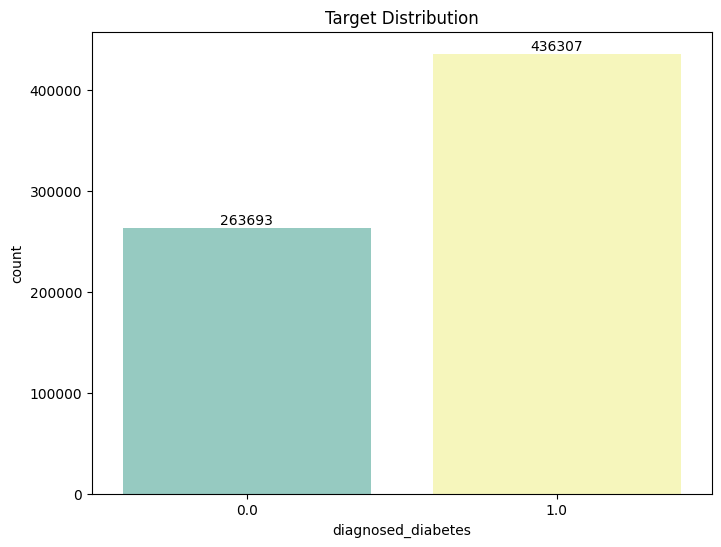

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=train, x=target, palette='Set3')
plt.title('Target Distribution')
for p in ax.patches:
    ax.annotate(int(p.get_height()), 
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='bottom', fontsize=10)

In [11]:
train['diagnosed_diabetes'].value_counts(normalize=True)

diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64

## Correlation Matrix
We analyze the correlation between the numerical features and the target. This heatmap helps identify multicollinearity and highlights features that have a strong linear relationship with the target.

<Axes: >

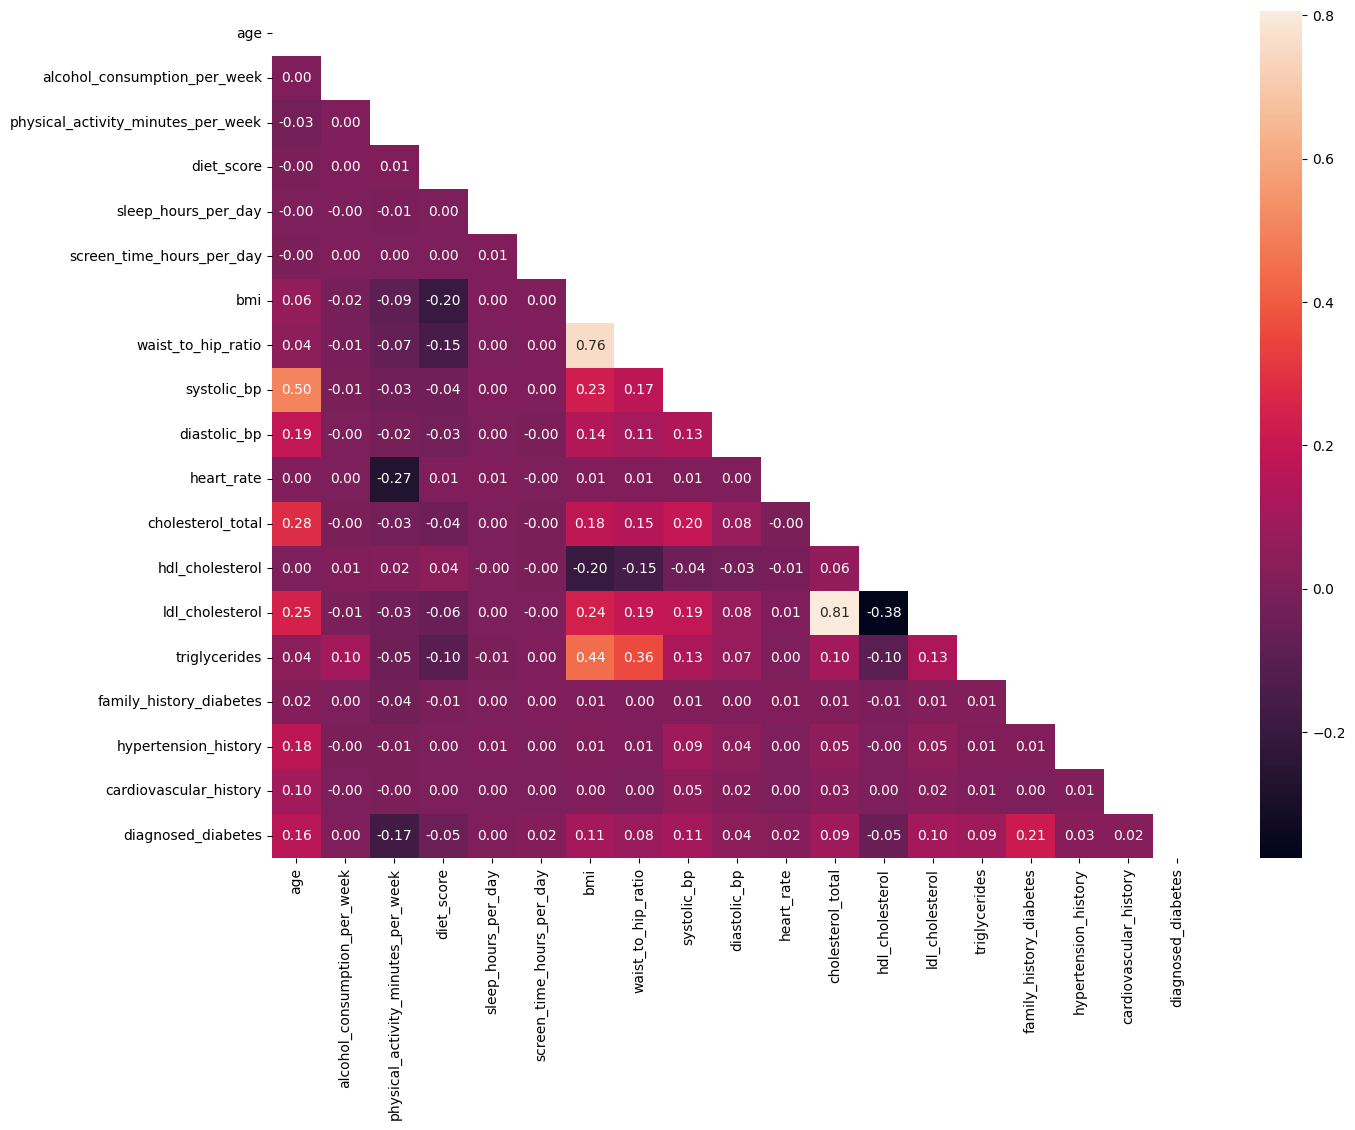

In [12]:
plt.figure(figsize=(15, 11))
corr_matrix = train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', mask=mask)

## Feature distributions using KDE plot

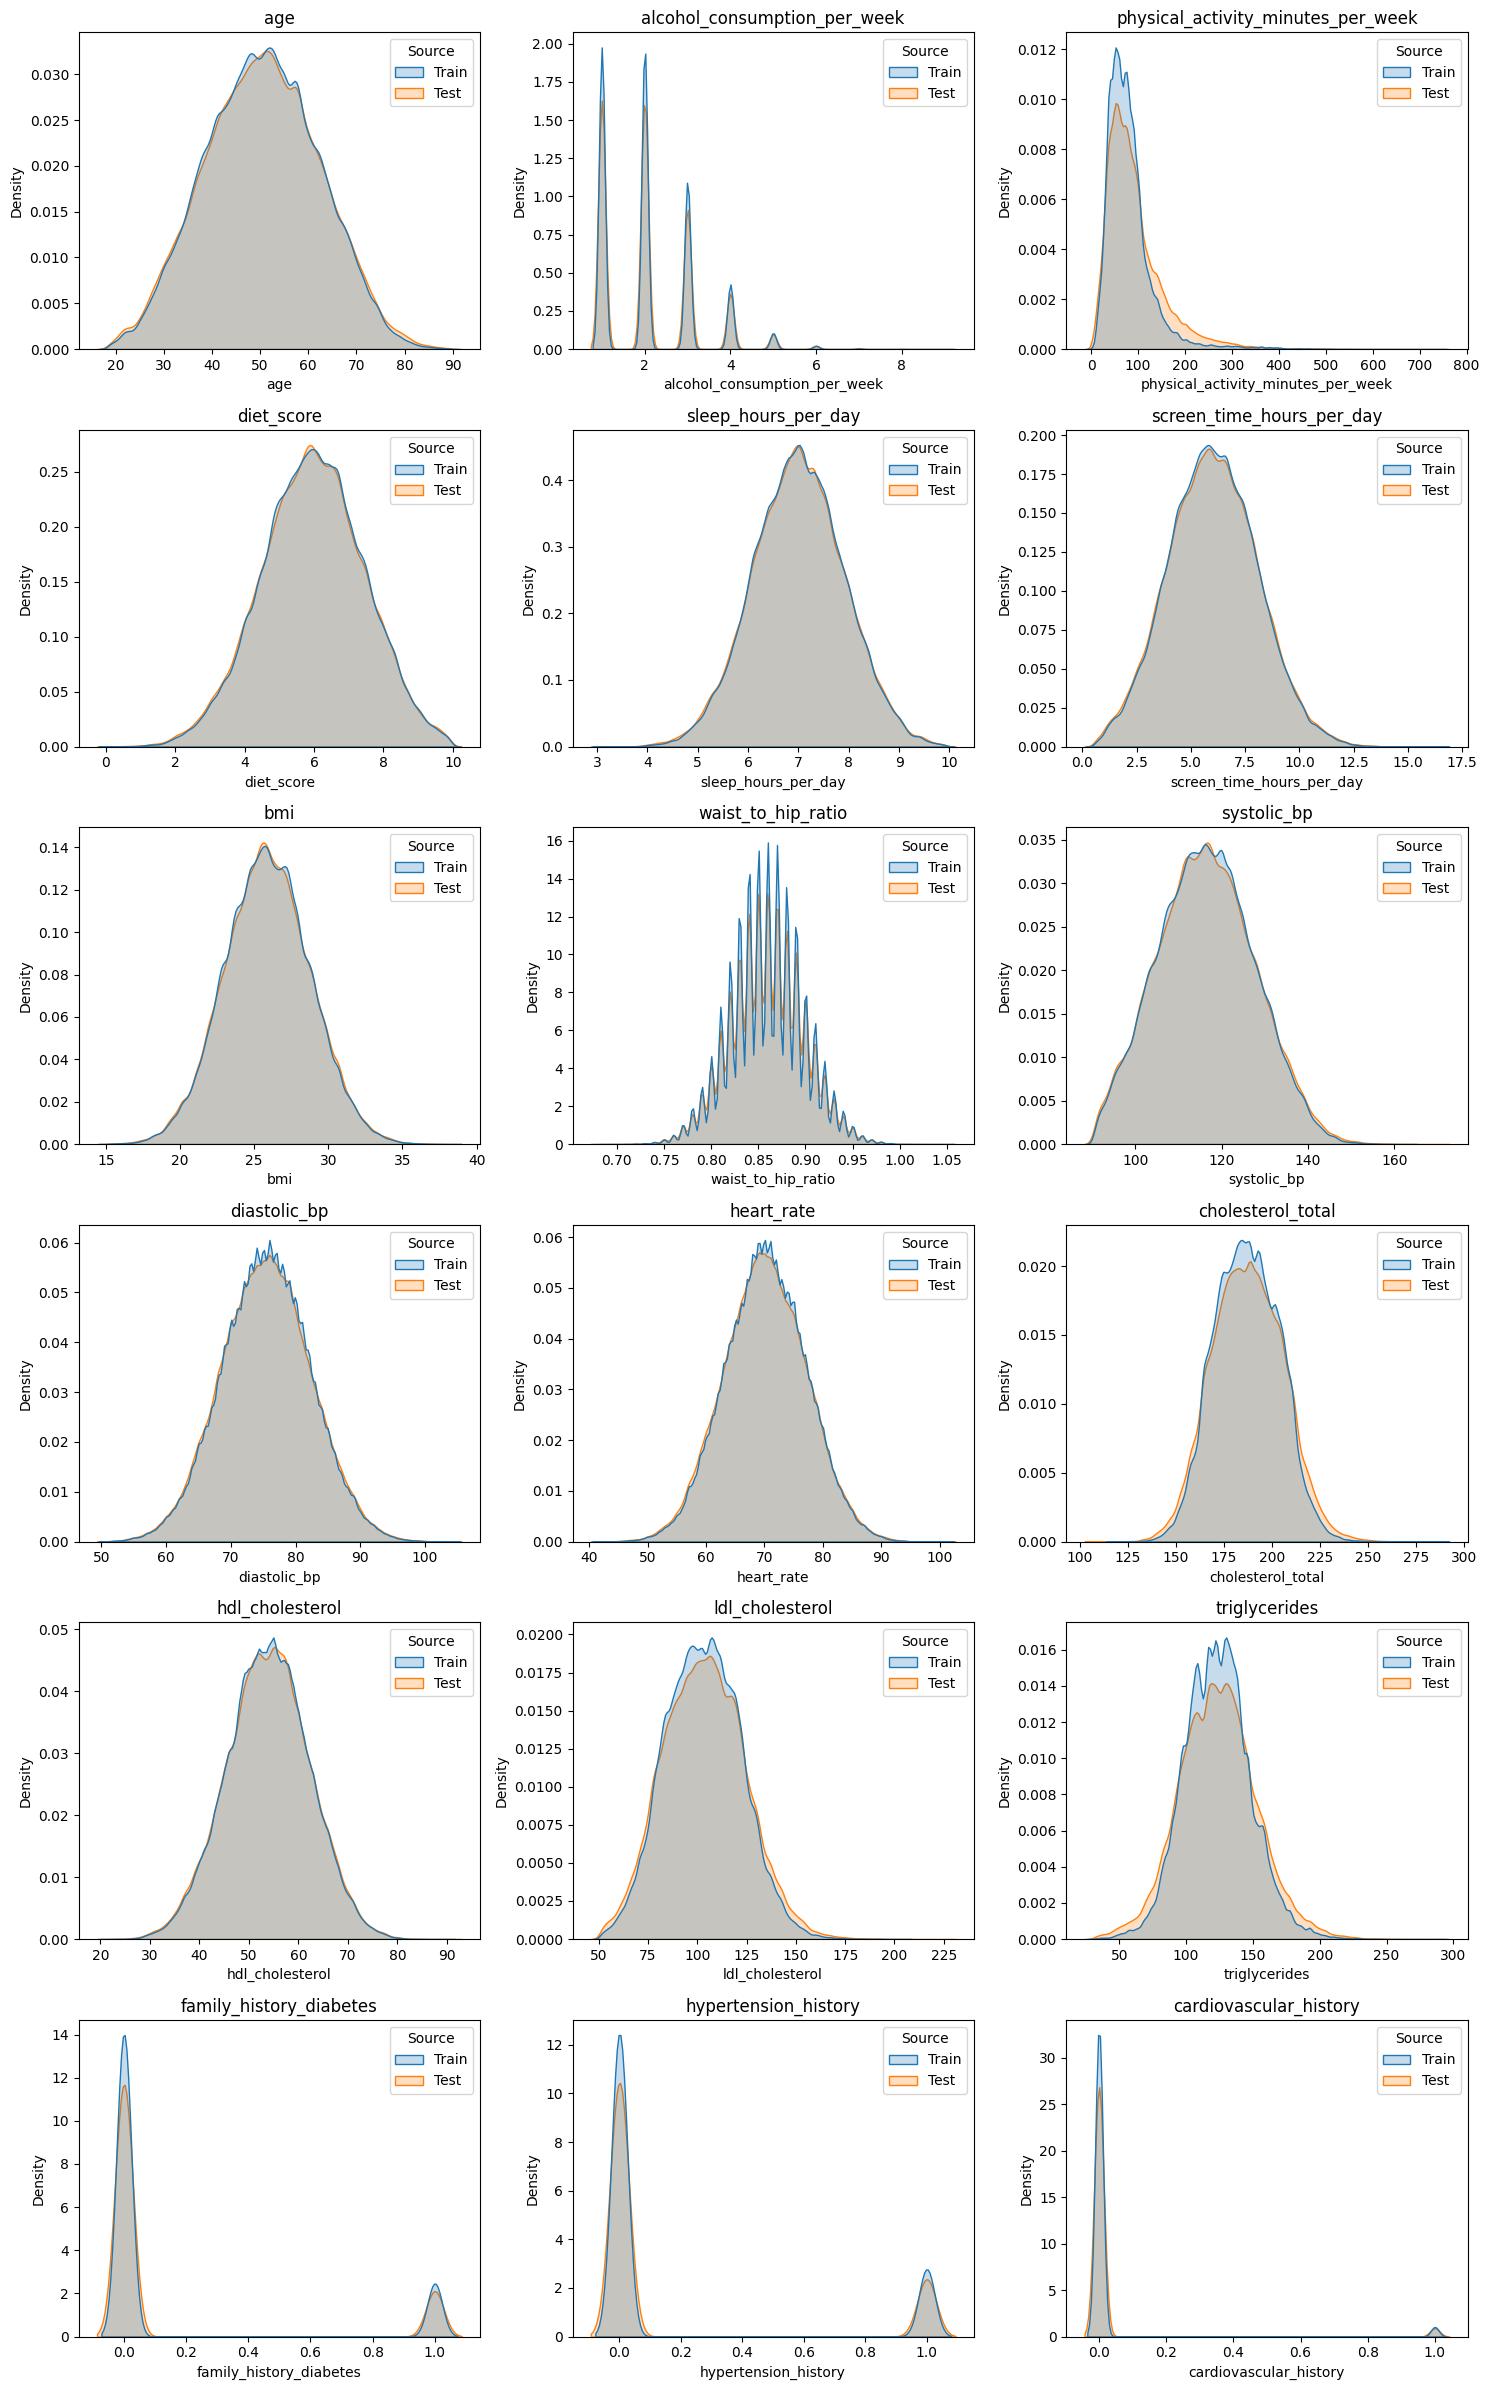

In [13]:
df_plot = pd.concat([
    train[num_cols].assign(Source='Train'),
    test[num_cols].assign(Source='Test')
])

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols # computes how many rows are needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=df_plot, x=col, ax=axes[i], hue='Source', fill=True, common_norm=False, warn_singular=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.savefig("kde_plots.png", dpi=300, bbox_inches="tight")
plt.show()

del df_plot

### Observation and findings

* Target distribution: We observe a class imbalancement since 62.32% of the target distribution belongs to 1.0. 
* Multicollinearity: We observe a strong correlation (0.76) between <code>waist_to_hip_ratio</code> and <code>bmi</code>, and correlation of 0.81 between <code>cholesterol_total</code> and <code>ldl_cholesterol</code>. While tree-based models like XGBoost can handle this, we should be aware of this redundancy whilst analysing feature importance.
* Feature distribution: Most features match closely between train and test, which is excellent for model generalization and validates our local CV strategy.
* Possible actions: Transform skewed variables like <code>physical_activity_minutes_per_week</code> using log or sqrt to reduce skewness and stabilize variance
  

## Boxplot for skewed variables
We analyze the skewed variables via boxplot to see there is an actual skewness or not.

Text(0.5, 1.0, 'Boxplot for Physical Activity')

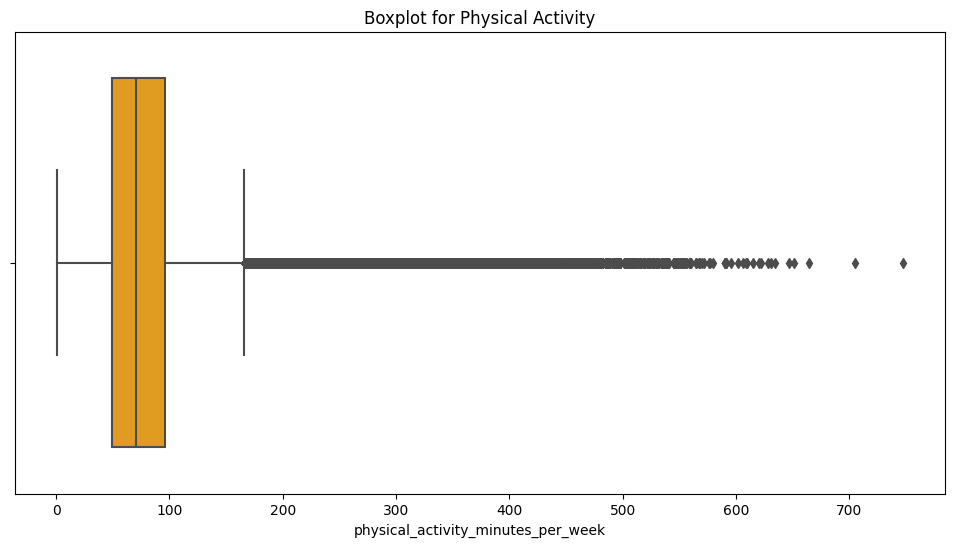

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=train['physical_activity_minutes_per_week'], color='orange')
plt.title('Boxplot for Physical Activity')

Text(0.5, 1.0, 'Boxplot for Triglycerides')

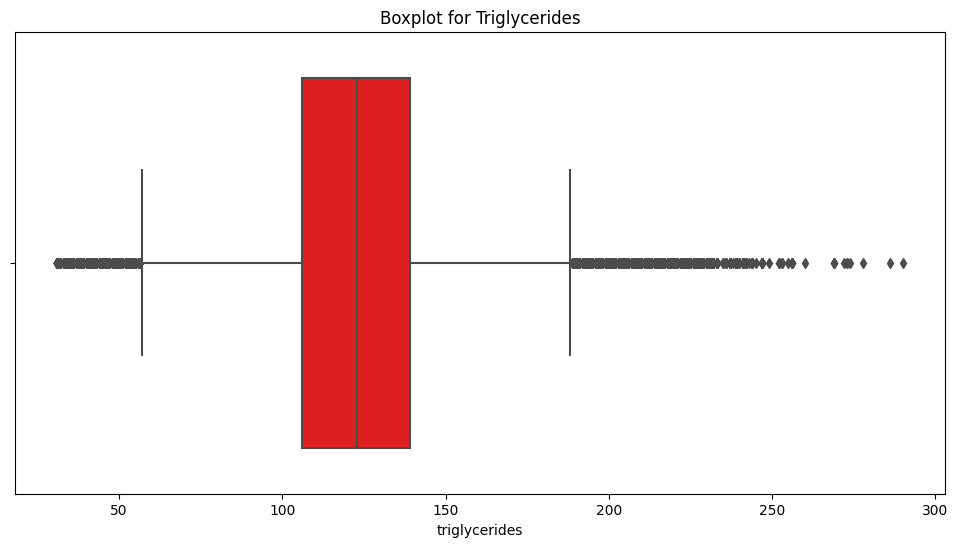

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=train['triglycerides'], color='red')
plt.title('Boxplot for Triglycerides')

### Observation 
* We see that both features have outliers, which requires further actions to be taken such as log or sqrt transformation.

## Non-linear transformation
We analyze skewed variables using log1p and sqrt transformation to see if we can achieve normal distribution.

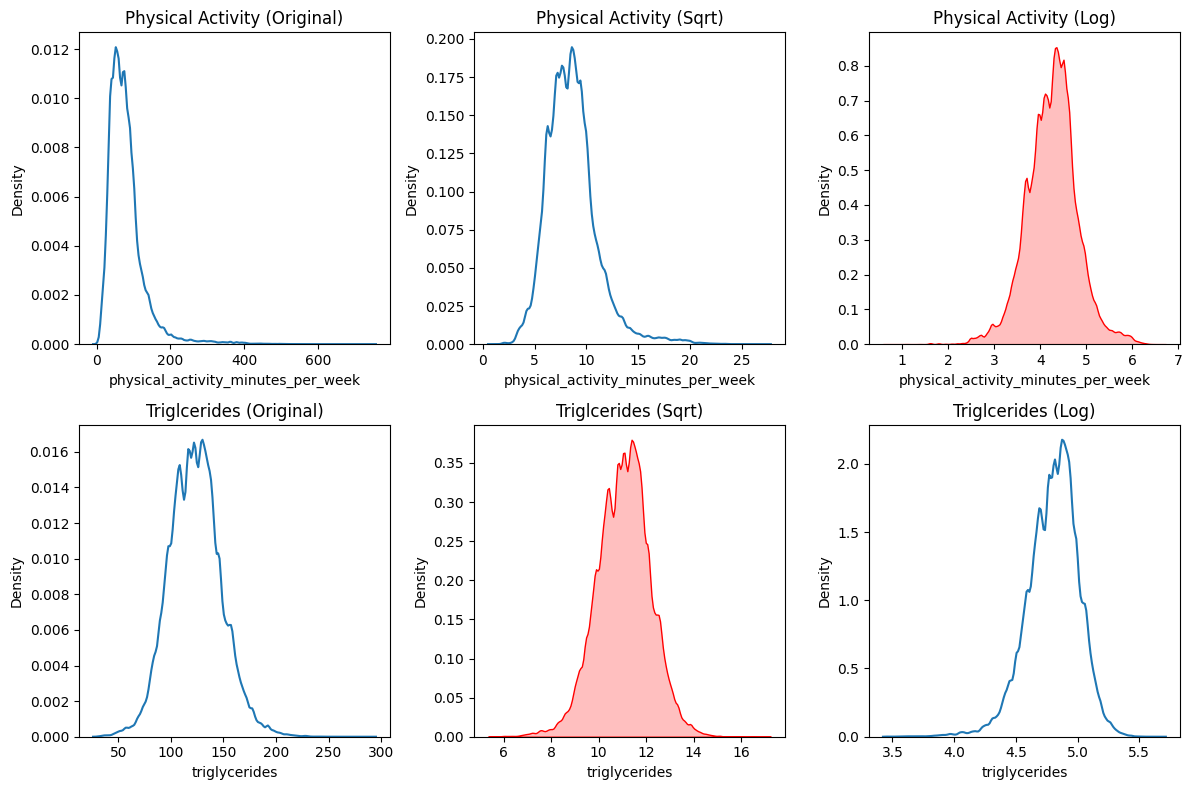

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

sns.kdeplot(train['physical_activity_minutes_per_week'], ax=axs[0, 0])
axs[0,0].set_title('Physical Activity (Original)')

sns.kdeplot(np.sqrt(train['physical_activity_minutes_per_week']), ax=axs[0, 1])
axs[0,1].set_title('Physical Activity (Sqrt)')

sns.kdeplot(np.log1p(train['physical_activity_minutes_per_week']), color='red', ax=axs[0, 2], fill=True)
axs[0,2].set_title('Physical Activity (Log)')

sns.kdeplot(train['triglycerides'], ax=axs[1, 0])
axs[1,0].set_title('Triglcerides (Original)')

sns.kdeplot(np.sqrt(train['triglycerides']), color='red', ax=axs[1, 1], fill=True)
axs[1,1].set_title('Triglcerides (Sqrt)')

sns.kdeplot(np.log1p(train['triglycerides']), ax=axs[1, 2])
axs[1,2].set_title('Triglcerides (Log)')

plt.savefig("kde_plots_outliers.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [17]:
from scipy.stats import skew

print("Original:", skew(train['triglycerides']))
print("Sqrt:", skew(np.sqrt(train['triglycerides'])))
print("Log:", skew(np.log1p(train['triglycerides'])))


Original: 0.1923528946628705
Sqrt: -0.19532763193215585
Log: -0.6350875249582595


### Observation and findings
* Boxplot: The boxplots for <code>physical_activity_minutes_per_week</code> and <code>triglycerides</code> shows that they are outliers leading to skewness.
* Non-linear transformation and kdeplot: For <code>physical_activity_minutes_per_week</code>, log transformation is the superior choice since the distribution becomes close to bell-shaped, center is clear and long tail is gone. For <code>triglycerides</code>, sqrt transformation is the superior choice since right tail is reduced just enough, peak stays near the center and shape looks balanced on both sides.
* Skew calculation: Skew calculation confirms that sqrt is the right choice, it is slighly left-skewed.
